## These models predict deltaI and deltaR using training data created with the MATLAB code ES_AG_Spec_v1 and a scale factor of 0.8993 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 

energy = (pd.read_csv('Training_Data/Graphene/GrapheneTrainingData180722_bias.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
# energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

# col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names

col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 

In [4]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Graphene/ES_AG_Spec_data_180729_sf_0.8993.csv', header = None)
data1.drop(data1.iloc[:, 3:454], inplace=True, axis=1)
data1.columns = col_names1
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,-0.29103,0.85577,0.51161,0.54012,0.54315,0.54645,0.54988,0.55320,0.55678,0.56011,...,0.73392,0.74050,0.74685,0.75307,0.75893,0.76452,0.76969,0.77448,0.77898,0.78279
1,-0.14798,0.67080,0.56185,0.58867,0.59314,0.59777,0.60243,0.60690,0.61155,0.61585,...,0.76948,0.77533,0.78089,0.78631,0.79133,0.79610,0.80046,0.80446,0.80819,0.81131
2,-1.37130,0.52359,0.34715,0.38517,0.37813,0.37176,0.36611,0.36062,0.35584,0.35128,...,0.56791,0.57679,0.58580,0.59497,0.60403,0.61302,0.62165,0.63000,0.63799,0.64511
3,-0.13607,0.29882,0.68938,0.70868,0.71788,0.72675,0.73518,0.74333,0.75127,0.75864,...,0.87596,0.88030,0.88432,0.88807,0.89142,0.89446,0.89715,0.89949,0.90162,0.90331
4,-0.57749,0.70397,0.43491,0.46150,0.46513,0.46909,0.47332,0.47753,0.48210,0.48652,...,0.72043,0.72832,0.73596,0.74340,0.75042,0.75707,0.76320,0.76882,0.77406,0.77846


In [5]:
# Manipulating Training Data 
# col_names1a = ['deltaI', 'deltaR'] + energy_names[50:] # this would be used if we wanted to exclude the first peak 

#X1 = data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
#Y1 = data1[['deltaI', 'deltaR', 'scale factor']]
X1 = data1.drop(['deltaI', 'deltaR'], axis = 1)
Y1 = data1[['deltaI', 'deltaR']]

In [6]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)

In [7]:
# Checking Spec points Data 
X1.head()

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.51161,0.54012,0.54315,0.54645,0.54988,0.55320,0.55678,0.56011,0.56385,0.56745,...,0.73392,0.74050,0.74685,0.75307,0.75893,0.76452,0.76969,0.77448,0.77898,0.78279
1,0.56185,0.58867,0.59314,0.59777,0.60243,0.60690,0.61155,0.61585,0.62046,0.62486,...,0.76948,0.77533,0.78089,0.78631,0.79133,0.79610,0.80046,0.80446,0.80819,0.81131
2,0.34715,0.38517,0.37813,0.37176,0.36611,0.36062,0.35584,0.35128,0.34745,0.34385,...,0.56791,0.57679,0.58580,0.59497,0.60403,0.61302,0.62165,0.63000,0.63799,0.64511
3,0.68938,0.70868,0.71788,0.72675,0.73518,0.74333,0.75127,0.75864,0.76615,0.77337,...,0.87596,0.88030,0.88432,0.88807,0.89142,0.89446,0.89715,0.89949,0.90162,0.90331
4,0.43491,0.46150,0.46513,0.46909,0.47332,0.47753,0.48210,0.48652,0.49149,0.49644,...,0.72043,0.72832,0.73596,0.74340,0.75042,0.75707,0.76320,0.76882,0.77406,0.77846


In [8]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,-0.29103,0.85577,0.51161,0.54012,0.54315,0.54645,0.54988,0.55320,0.55678,0.56011,...,0.73392,0.74050,0.74685,0.75307,0.75893,0.76452,0.76969,0.77448,0.77898,0.78279
1,-0.14798,0.67080,0.56185,0.58867,0.59314,0.59777,0.60243,0.60690,0.61155,0.61585,...,0.76948,0.77533,0.78089,0.78631,0.79133,0.79610,0.80046,0.80446,0.80819,0.81131
2,-1.37130,0.52359,0.34715,0.38517,0.37813,0.37176,0.36611,0.36062,0.35584,0.35128,...,0.56791,0.57679,0.58580,0.59497,0.60403,0.61302,0.62165,0.63000,0.63799,0.64511
3,-0.13607,0.29882,0.68938,0.70868,0.71788,0.72675,0.73518,0.74333,0.75127,0.75864,...,0.87596,0.88030,0.88432,0.88807,0.89142,0.89446,0.89715,0.89949,0.90162,0.90331
4,-0.57749,0.70397,0.43491,0.46150,0.46513,0.46909,0.47332,0.47753,0.48210,0.48652,...,0.72043,0.72832,0.73596,0.74340,0.75042,0.75707,0.76320,0.76882,0.77406,0.77846


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.023809215276624014 for  deltaI Depth 60
R^2 Score on test data: 0.9971554548352398 for deltaI Depth 60
 
RMSE on test data: 0.02244696942547446 for  deltaR Depth 60
R^2 Score on test data: 0.9943439923224542 for deltaR Depth 60


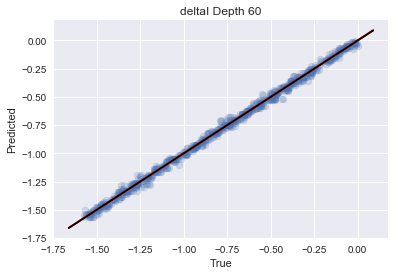

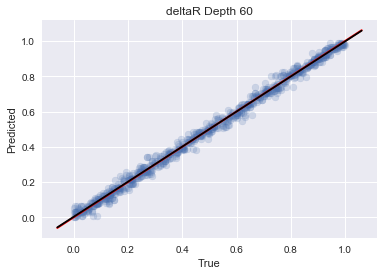

In [9]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [10]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)
features_sp_DT_sorted

,Spec - DT
E_480_mV,0.532787
E_134_mV,0.107278
E_358_mV,0.105316
E_262_mV,0.038974
E_-394_mV,0.037307
E_372_mV,0.031114
E_14_mV,0.027004
E_264_mV,0.010043
E_328_mV,0.009630
E_-22_mV,0.008602


## Random Forest

### spec points

 
RMSE on test data: 0.008169253815747658 for  deltaI RF spec
R^2 Score on test data: 0.9996651213583425 for deltaI RF spec
 
RMSE on test data: 0.009421120498168524 for  deltaR RF spec
R^2 Score on test data: 0.9990036780982104 for deltaR RF spec


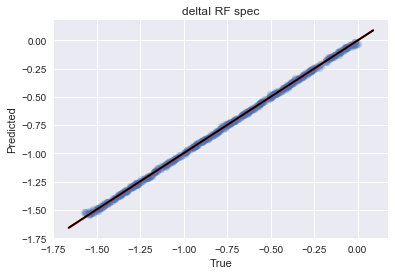

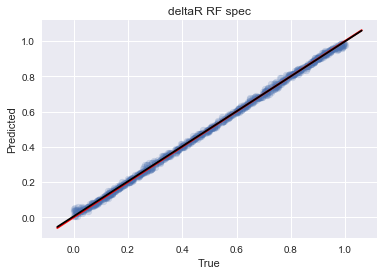

In [11]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
#plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [12]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)
features_sp_RF_sorted

,Spec - RF
E_476_mV,0.176959
E_480_mV,0.108291
E_482_mV,0.071114
E_-340_mV,0.053668
E_478_mV,0.035554
E_130_mV,0.026321
E_358_mV,0.024561
E_342_mV,0.024372
E_132_mV,0.021937
E_134_mV,0.021095


## Independent Random Forests

### spec points


Score - Random Forest: 0.9994658154072505 for deltaR IRF
 
RMSE on test data: 0.006898400407053197 for  deltaR 10
R^2 Score on test data: 0.9994658154072505 for deltaR 10
 
RMSE on test data: 0.004457306366365482 for  deltaI 10
R^2 Score on test data: 0.9999003063167665 for deltaI 10


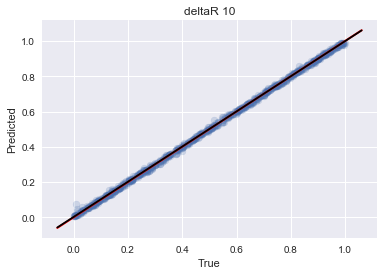

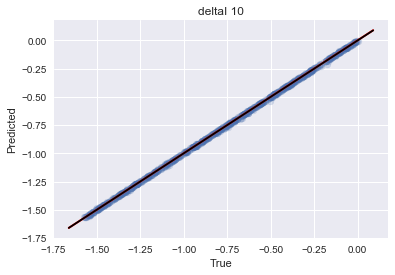

In [13]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
#model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
#predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
#plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [14]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
#FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
#FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
#features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
#features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)
#features_sp_RF2_sf_sorted

## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.00519897702772019 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9998643691551389 for AdaBoost Delta I SP
 
RMSE on test data: 0.007361109942427803 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9993917513289794 for AdaBoost Delta R SP
Delta I AdaBoost Score: 0.9998643691551389
Delta R AdaBoost Score: 0.9993917513289795


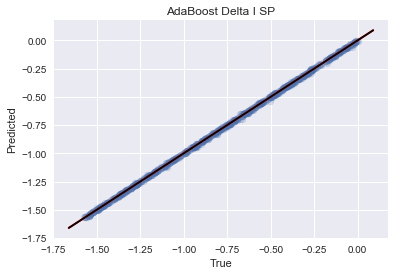

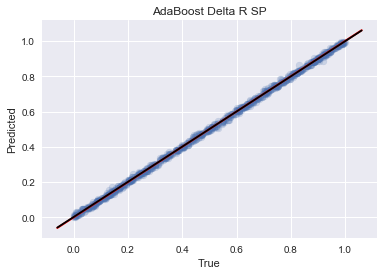

In [15]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
#predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
#print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [16]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
#FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
#FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
#features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
#features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)
#features_sp_AB_sf_sorted

## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.019961383834064778 for  GradientBoost Delta I SP
R^2 Score on test data: 0.9980005803244486 for GradientBoost Delta I SP
 
RMSE on test data: 0.01898854770789254 for  GradientBoost Delta R SP
R^2 Score on test data: 0.9959525819849264 for GradientBoost Delta R SP


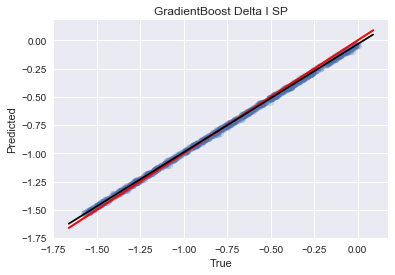

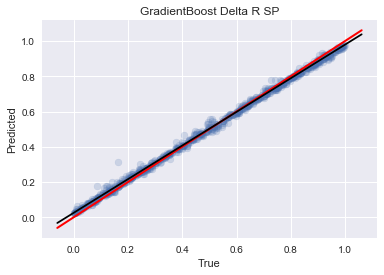

In [17]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
#predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [18]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
#FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
#FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
#features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
#features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)
#features_sp_GB_sf_sorted

In [19]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_476_mV,0.176959
E_480_mV,0.108291
E_482_mV,0.071114
E_-340_mV,0.053668
E_478_mV,0.035554
E_130_mV,0.026321
E_358_mV,0.024561
E_342_mV,0.024372
E_132_mV,0.021937
E_134_mV,0.021095


In [20]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_476_mV,0.176959
E_480_mV,0.108291
E_482_mV,0.071114
E_-340_mV,0.053668
E_478_mV,0.035554
E_130_mV,0.026321
E_358_mV,0.024561
E_342_mV,0.024372
E_132_mV,0.021937
E_134_mV,0.021095


In [21]:
#display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

## Testing the Models on the Experimental Data



In [22]:
# Load the experimental data
# Load experimental data
exp_data_sp = pd.read_csv('Training_Data/Graphene/ES_AG_Exp_data.csv', header = None, names = ['deltaI', 'deltaR']+energy_names+energy_names)
exp_data_sp = exp_data_sp.drop(['deltaI', 'deltaR'], axis = 1)
exp_data_sp.drop(exp_data_sp.iloc[:, 0:451], inplace=True, axis=1)



C:\Users\emory\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [23]:

exp_data_sp

,E_-400_mV.1,E_-398_mV.1,E_-396_mV.1,E_-394_mV.1,E_-392_mV.1,E_-390_mV.1,E_-388_mV.1,E_-386_mV.1,E_-384_mV.1,E_-382_mV.1,...,E_482_mV.1,E_484_mV.1,E_486_mV.1,E_488_mV.1,E_490_mV.1,E_492_mV.1,E_494_mV.1,E_496_mV.1,E_498_mV.1,E_500_mV.1
0,0.75074,1.1104,1.002,1.0652,1.0312,1.0583,1.0443,1.0557,1.0519,1.0571,...,1.0368,1.0407,1.0411,1.0484,1.0385,1.0555,1.0324,1.072,1.0134,1.128


In [25]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
 #                            r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T


In [26]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)


pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
#pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)



pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
#pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)


pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
#pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)


In [27]:
#predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])

In [28]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
#RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

In [29]:
#predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1],  RF_sp_di_r2score, RF_sp_dr_r2score)

In [30]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
#AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)


In [31]:
#predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score)


In [32]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
#GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)


In [33]:
#predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0],  GB_sp_di_r2score, GB_sp_dr_r2score)

In [34]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
#IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

In [35]:
#predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score)


In [36]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,-0.023932,0.003217,0.997155,0.994344
Random Forest spec points,-0.107988,0.156796,0.999665,0.999004
AdaBoost spec points,-0.068904,0.181600,0.999864,0.999392
Gradient Boosting spec points,-0.095831,0.231041,0.998001,0.995953
Independent Random Forests spec points,-0.065183,0.168877,0.999900,0.999466


In [37]:
# Sorting Predicted Phases Dataframe 
predictedPhases.sort_values(by=['deltaR score'])

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,-0.023932,0.003217,0.997155,0.994344
Gradient Boosting spec points,-0.095831,0.231041,0.998001,0.995953
Random Forest spec points,-0.107988,0.156796,0.999665,0.999004
AdaBoost spec points,-0.068904,0.181600,0.999864,0.999392
Independent Random Forests spec points,-0.065183,0.168877,0.999900,0.999466


In [38]:
# Predictions with 0.95 or lower scores excluded 
#GoodPredictedDeltaI = predictedPhases.drop([], axis = 0)
#GoodPredictedDeltaR = predictedPhases.drop([], axis = 0)
#GoodPredictedScaleFactor = predictedPhases.drop([], axis = 0)

GoodPredictedDeltaI = predictedPhases
GoodPredictedDeltaR = predictedPhases


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
#scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
#print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  0.14804414961229634  +  -0.07230508968062206 *i


In [40]:
#predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Graphene/predictions_180722_sf.csv')
#predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Graphene/scores_180722_sf.csv')

predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Graphene/predictions_180729_0.8993.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Graphene/scores_180729_0.8993.csv')




In [42]:
importance_DT_ = pd.Series(regr_DT_sp.feature_importances_, index = X1_train.columns)
importance_DT_ = pd.Series(regr_DT_sp.feature_importances_, index = X1_train.columns)
importance_RF_= pd.Series(model_RF_sp.feature_importances_, index = X1_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_sp.feature_importances_, index = X1_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_sp.feature_importances_, index = X1_train.columns)
#importance_IRF_sf = pd.Series(model_RF2_sf_sp.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_sp.feature_importances_, index = X1_train.columns)
importance_ARF_i = pd.Series(model_AB_di_sp.feature_importances_, index = X1_train.columns)
#importance_ARF_sf = pd.Series(model_AB_sf_sp.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_sp.feature_importances_, index = X1_train.columns)
importance_GRF_i = pd.Series(model_GB_di_sp.feature_importances_, index = X1_train.columns)
#importance_GRF_sf = pd.Series(model_GB_sf_sp.feature_importances_, index = X_train.columns)

In [43]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
#IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
#ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
#GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_220_mV     1
E_478_mV     1
E_474_mV     1
E_348_mV     1
E_342_mV     1
E_32_mV      1
E_328_mV     1
E_314_mV     1
E_278_mV     1
E_274_mV     1
E_264_mV     1
E_262_mV     1
E_14_mV      1
E_144_mV     1
E_130_mV     1
E_0_mV       1
E_486_mV     1
E_-22_mV     1
E_-338_mV    1
E_-340_mV    1
E_-352_mV    1
E_-366_mV    1
E_-68_mV     1
E_-66_mV     1
E_-368_mV    1
E_-388_mV    1
E_-80_mV     1
E_-78_mV     2
E_372_mV     2
E_358_mV     2
E_310_mV     2
E_308_mV     2
E_306_mV     2
E_302_mV     2
E_-390_mV    2
E_484_mV     2
E_18_mV      2
E_146_mV     2
E_-74_mV     2
E_134_mV     2
E_132_mV     2
E_-160_mV    2
E_276_mV     3
E_-394_mV    3
E_-72_mV     3
E_476_mV     3
E_482_mV     3
E_304_mV     3
E_480_mV     5
dtype: int64

In [44]:
#sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
#sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
#sf_tops_count = sf_tops.groupby(level=[0]).size()
#sf_tops_count.sort_values(axis = 0)
#sf_tops_count = sf_tops_count.sort_values()
#sf_tops_count

Text(0,0.5,'Feature Importance')

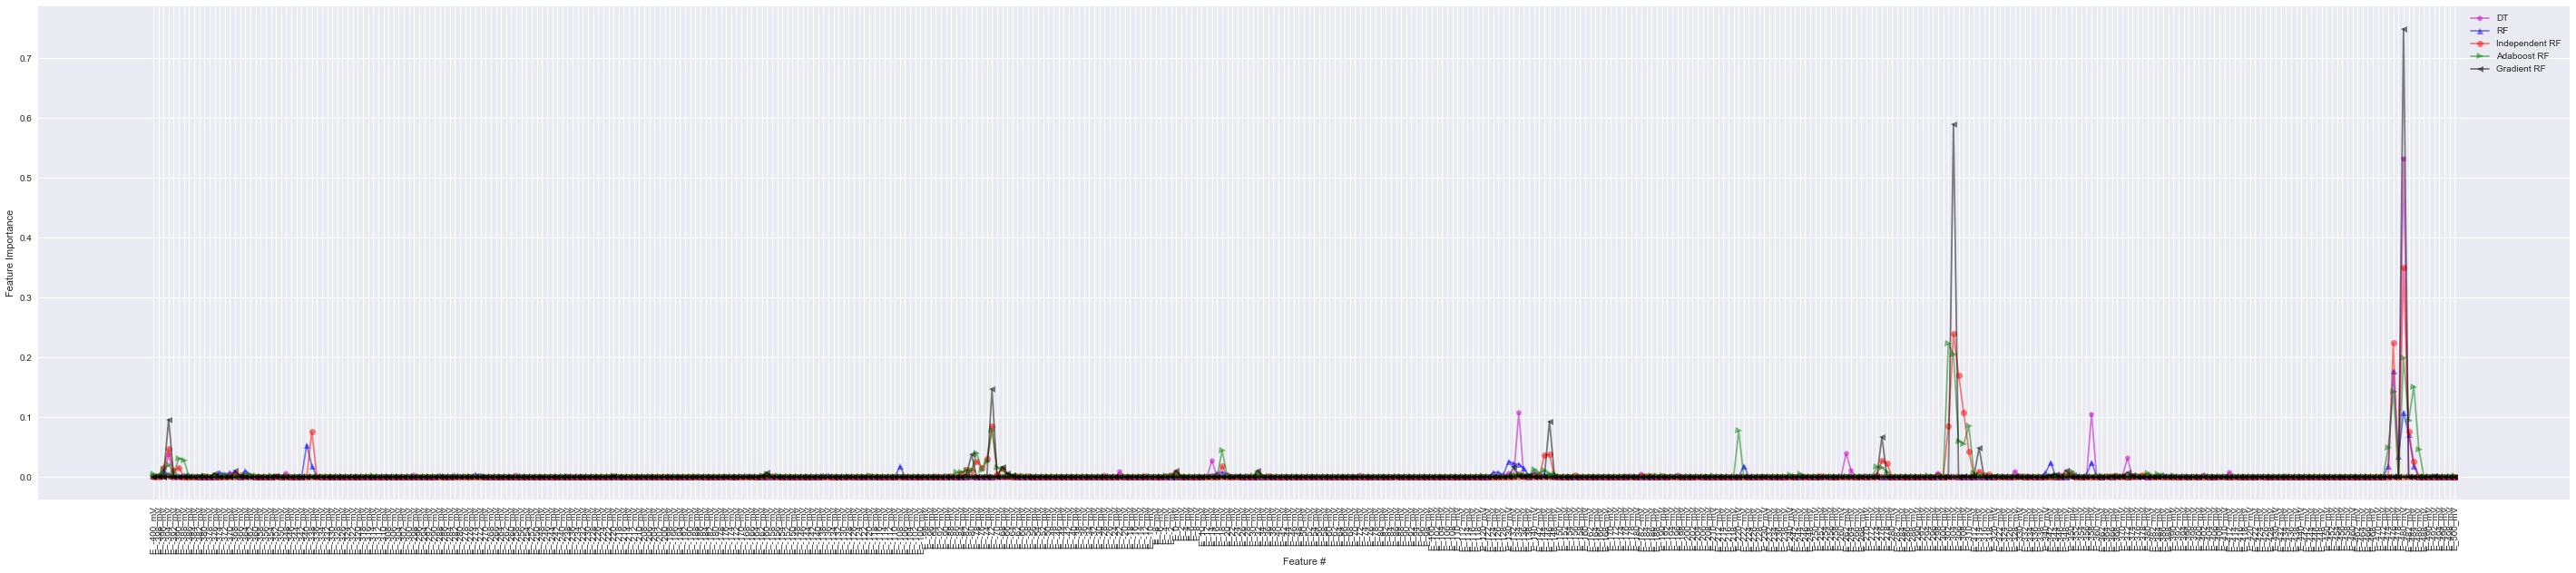

In [50]:
Features = linspace(0,451, 451)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, energy_names, rotation = 'vertical')
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

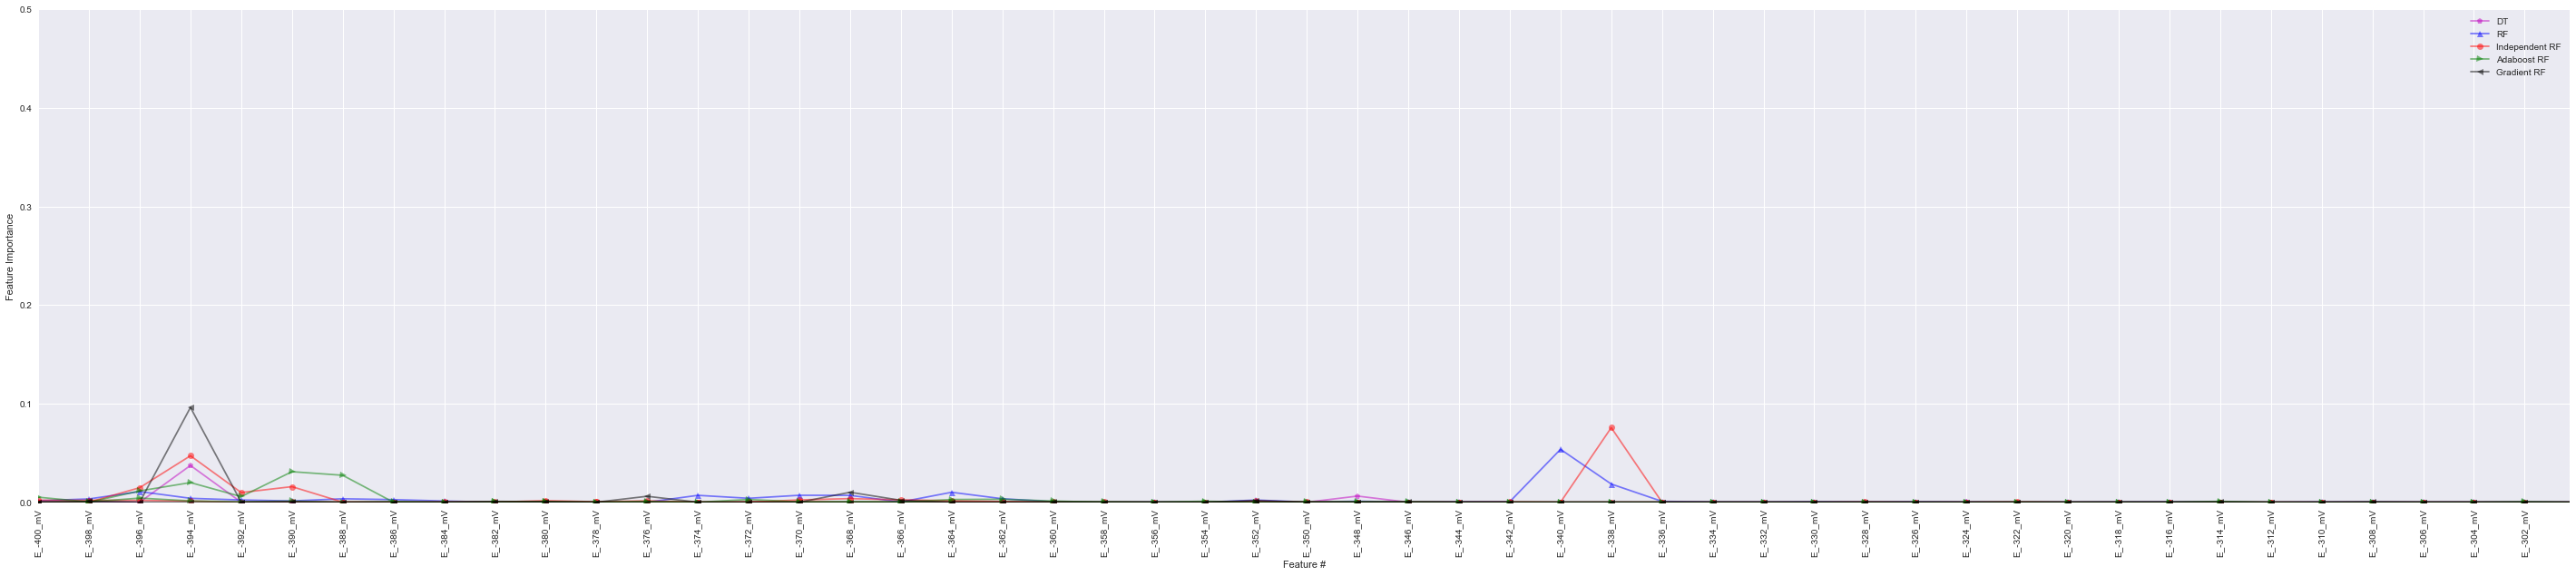

In [51]:
Features = linspace(0,451, 451)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, energy_names, rotation = 'vertical')
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.50])
xlim([0, 50])